# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [14]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices


def calc_prec_average(mpr_min, mpr_max, rainsignal, month, ymin, ymax):
    
    # initialize accumulators
    indices = []
    distribution = []
    raininput = 0
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == month and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    

            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                raininput += mpr
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Stat routines

In [15]:
from os.path import basename
from scipy.stats import spearmanr

def linear_regression(x, y): 
    coefs = np.polynomial.polynomial.polyfit(x, y, 1)
    ffit = np.poly1d(coefs)
    m = ffit[0]
    b = ffit[1] 
    eq = 'y = {}x + {}'.format(round(m, 3), round(b, 3))
    pc = np.corrcoef(x, y)[0, 1]
                  
    return pc, eq, m, b



def plot_scatter(X, Y, title):     

    print ("model:", title)


    # plot best fit line
    pc, eq, m, b = linear_regression(X,Y)
    xmaxreg = max(X)
    ymaxreg = b + m*xmaxreg
    if ymaxreg > max(Y): 
        xmaxreg = (max(Y)-b) / m
    plt.plot([0,xmaxreg], [b, b + m*xmaxreg], c = 'r', label=eq)
    
    #rowtitle = '.'.join(sigfilename.split('.')[0:4])
    rowtitle = title
    #plt.scatter(X, Y, color="tab:blue", s=1, label='prec (mm/day)')
    plt.scatter(X, Y, color="tab:blue", label='prec (mm/day)')


    # legend
    r2_text = 'R² = {}'.format(round(pc**2, 3))
    r2_text += '\nPC = {}'.format(round(pc, 3))
    #print(spearmanr(rs1,rs2))
    sc, delme = spearmanr(X,Y)
    r2_text += '\nSC = {}'.format(round(sc, 3))
    rmse = ((np.array(X)-np.array(Y))**2).mean()**0.5
    r2_text += '\nRMSE = {}'.format(round(rmse, 3)) 
    plt.legend(loc="lower right", title=r2_text)
    
    # draw 1:1 line
    X = np.linspace(0, .03, num=50) 
    plt.plot(X, X, 'x')


#     # title
#     sigfilename = basename(sigfile)
#     title = sigfilename.split('.')[5] + ' ' + '.'.join(sigfilename.split('.')[7:10])
#     plt.title( title.upper()+' vs. obs' )
    plt.title( title )
                
    plt.show()
    

# Run over all models

In [67]:
# raw baselines (to be compared against)
hist_baseline = []
rcp85_baseline = []
baseline = []         # change from hist to rcp85

# use raw as baseline
names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfn1 = sigfiles_hist[0]
sigfn2 = sigfiles_rcp85[0]
rainsignal1 = xr.open_dataset(sigfn1)['prec']
rainsignal2 = xr.open_dataset(sigfn2)['prec']


load_uatm_mpi_hist()
for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
    #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
    baseline_avg_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
    hist_baseline.append(baseline_avg_hist)
    
load_uatm_mpi_future()
for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
    baseline_avg_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
    rcp85_baseline.append(baseline_avg_rcp85)
    
for ii in range(4):
    baseline.append(rcp85_baseline[ii] - hist_baseline[ii])

In [68]:
baseline[0].shape

(8, 18, 18)

In [69]:
baseline[0][0].flatten().shape

(324,)

### future-hist (change signal)

In [110]:
# Calculate parameters for Taylor plots: dry/moist/wet

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# interate over models
XX=[]; YY=[]; ZZ=[]
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    sigfn2 = sigfiles_rcp85[mii]

    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    rainsignal2 = xr.open_dataset(sigfn2)['prec']

    X=[]
    load_uatm_mpi_hist()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
        X.append(avginput_hist)
    
    Y=[]
    load_uatm_mpi_future()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        Y.append(avginput_rcp85)
        
    # baseline: raw
    if mii == 0:
        baseline_hist = np.array(X)
        baseline_rcp85 = np.array(Y)
 
        
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            
            diff = np.array(Y[ii][vii]) - np.array(X[ii][vii])
            diffbaseline = np.array(baseline_rcp85[ii][vii]) - np.array(baseline_hist[ii][vii])
            
            sd = np.std(diff)
            cr = ((diff-diffbaseline)**2).mean()**0.5
            sc, delme = spearmanr(diffbaseline.flatten(),diff.flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            print(mii, vii, float(sd), float(cr), float(sc))
            
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)

    XX.append(sd83)
    YY.append(cr83)
    ZZ.append(sc83)


0 0 0.7664098442901175 0.0 1.0
0 0 0.6958798652992411 0.0 1.0
0 0 0.66873964384564 0.0 1.0
0 0 0.6000515973416434 0.0 1.0
0 1 0.7362773064657948 0.0 1.0
0 1 0.6113446234572267 0.0 1.0
0 1 0.7506072656873077 0.0 1.0
0 1 0.5493148606989265 0.0 1.0
0 2 0.000445435572681034 0.0 1.0
0 2 0.0005234424576816928 0.0 1.0
0 2 0.0006469131284435396 0.0 1.0
0 2 0.0004620824945491147 0.0 1.0
0 3 0.5974018555950741 0.0 1.0
0 3 0.7834251367118772 0.0 1.0
0 3 0.701716697190349 0.0 1.0
0 3 0.6505867825566634 0.0 1.0
0 4 9.60776065716385 0.0 1.0
0 4 8.48465958778199 0.0 1.0
0 4 9.940535636068129 0.0 1.0
0 4 9.466468517545866 0.0 1.0
0 5 12.780847163908954 0.0 1.0
0 5 13.165296963272686 0.0 1.0
0 5 13.579716152572189 0.0 1.0
0 5 13.051342249673473 0.0 1.0
0 6 3.121556325603014 0.0 1.0
0 6 2.3786158637148 0.0 1.0
0 6 2.3426080433426764 0.0 1.0
0 6 2.6447136918541534 0.0 1.0
0 7 1.8296071488223757 0.0 1.0
0 7 1.76969657077552 0.0 1.0
0 7 3.3033866588372574 0.0 1.0
0 7 2.1278910373952193 0.0 1.0
1 0 0.680963

5 0 0.7361506967865636 0.13423881077143962 0.9793033614705443
5 0 0.7488249158247358 0.4286219628242475 0.8165412237959003
5 0 0.7119204105821424 0.08743975564405383 0.992695262540464
5 0 0.6000515973416434 0.0 1.0
5 1 0.7324165895650964 0.10613019679245846 0.9927538302770503
5 1 0.6559735315148413 0.5332071474625105 0.560433612941353
5 1 0.8542044392207802 0.14590022482189333 0.9920182053928185
5 1 0.5493148606989265 0.0 1.0
5 2 0.0004452690840423418 7.20702106887749e-05 0.9897464122851122
5 2 0.0005394203575679891 0.00020637370010148122 0.9393774531855029
5 2 0.0006614680151356518 6.427996676851923e-05 0.9947218473534264
5 2 0.0004620824945491147 0.0 1.0
5 3 0.6418959562747125 0.13752807433359998 0.9843176064847894
5 3 0.7993922249974768 0.21584150673297406 0.9566161255325344
5 3 0.6985544614077173 0.11435460990928137 0.9836363155248605
5 3 0.6505867825566634 0.0 1.0
5 4 9.865599943430523 1.6313563647684133 0.9905275506513898
5 4 8.206637891316046 3.6812511369671026 0.824105210235241

In [111]:
np.array(XX).shape

(8, 8, 4)

In [112]:
np.array(XX)[:,0,2]

array([0.66873964, 0.58377739, 0.67149233, 0.62127885, 0.71727483,
       0.71192041, 0.73697289, 0.67525896])

Variable:  U850 m/s


<Figure size 432x288 with 0 Axes>

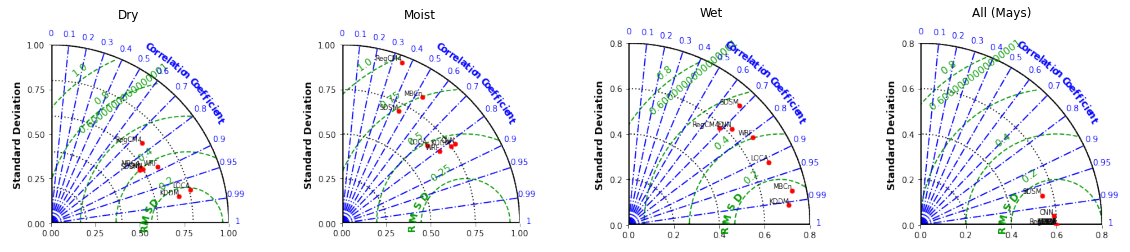

Variable:  V850 m/s


<Figure size 432x288 with 0 Axes>

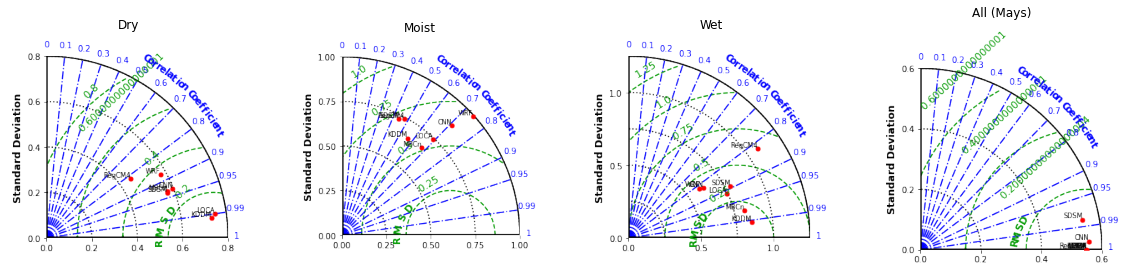

Variable:  Q850 kg/kg


<Figure size 432x288 with 0 Axes>

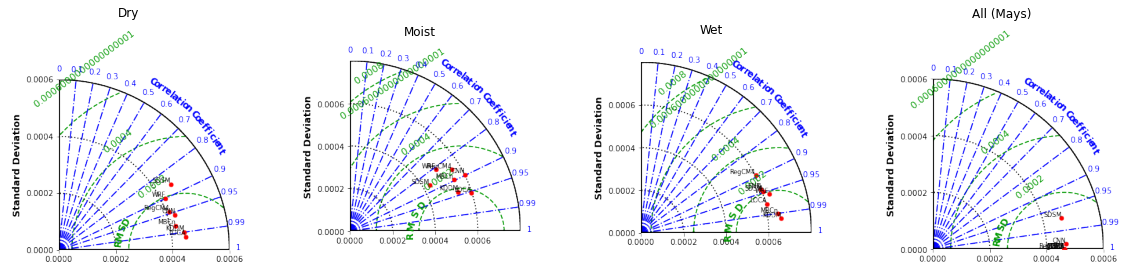

Variable:  T700 K


<Figure size 432x288 with 0 Axes>

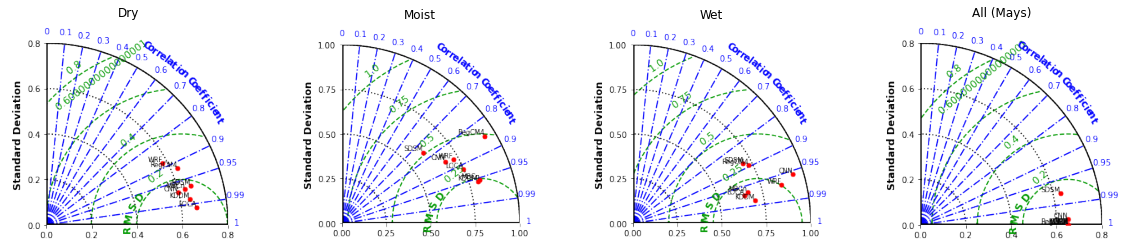

Variable:  Z700 mb


<Figure size 432x288 with 0 Axes>

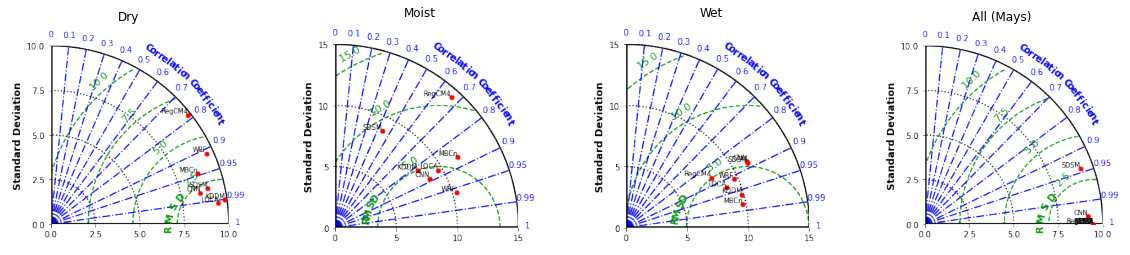

Variable:  Z500 mb


<Figure size 432x288 with 0 Axes>

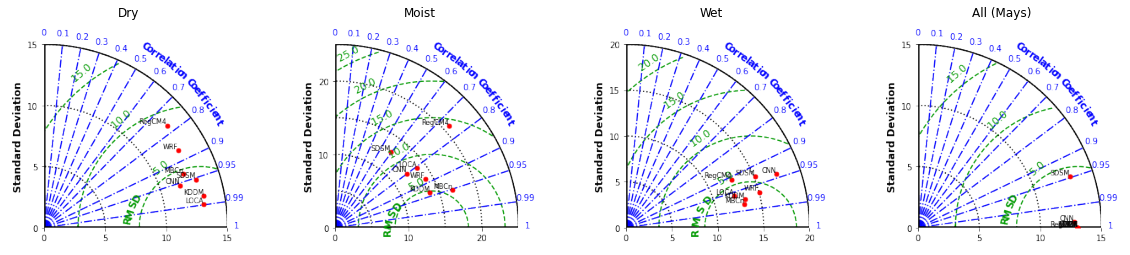

Variable:  U250 m/s


<Figure size 432x288 with 0 Axes>

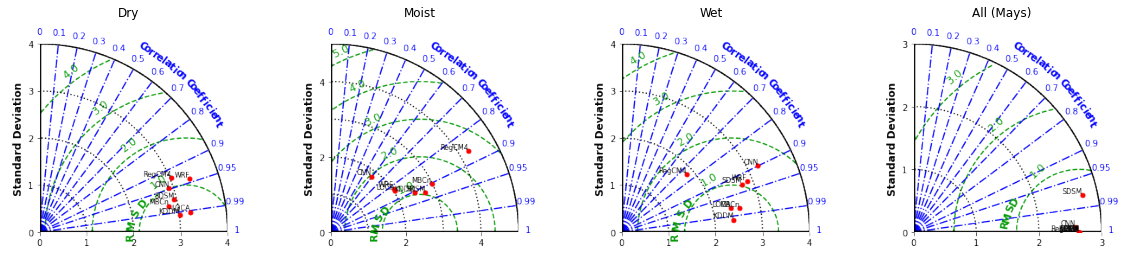

Variable:  V250 m/s


<Figure size 432x288 with 0 Axes>

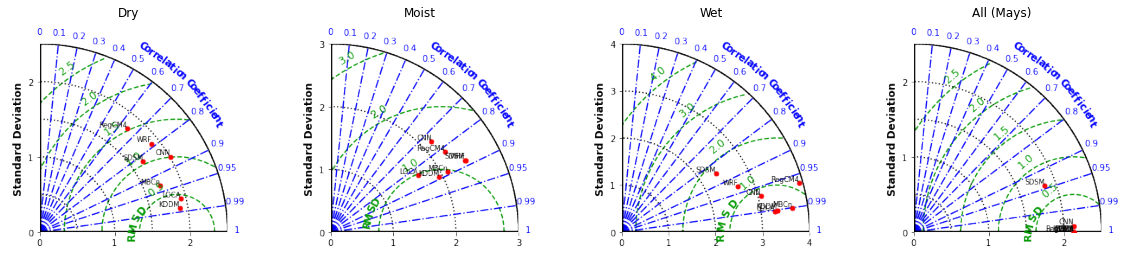

In [113]:
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    print("Variable: ", varmames[vii], units[vii])

    sm.taylor_diagram(np.array(XX)[:,vii,0], np.array(YY)[:,vii,0], np.array(ZZ)[:,vii,0], markerLabel=names)
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(XX)[:,vii,1], np.array(YY)[:,vii,1], np.array(ZZ)[:,vii,1], markerLabel=names)
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(XX)[:,vii,2], np.array(YY)[:,vii,2], np.array(ZZ)[:,vii,2], markerLabel=names)
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(XX)[:,vii,3], np.array(YY)[:,vii,3], np.array(ZZ)[:,vii,3], markerLabel=names)
    plt.savefig(buf4, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    img4 = Image.open(buf4)

    # plot png inside a grid layout
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Wet')
    
    axarr[3].imshow(img4)
    axarr[3].axis('off')
    axarr[3].set_title('All (Mays)')
    

    plt.show()


### Hist anomalies

In [77]:
# # Calculate parameters for Taylor plots: Historical anomalies for dry/moist/wet/all

# names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
# sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]
# sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# # interate over models
# HAXX=[]; HAYY=[]; HAZZ=[]
# for mii in range(len(sigfiles_hist)):
#     sigfn1 = sigfiles_hist[mii]
#     sigfn2 = sigfiles_rcp85[mii]

#     rainsignal1 = xr.open_dataset(sigfn1)['prec']
#     rainsignal2 = xr.open_dataset(sigfn2)['prec']

#     X=[]
#     load_uatm_mpi_hist()
#     for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#         avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
#         #avginput1, count1, distribution1, indices1 = calc_prec_average(0, 0.254, rainsignal2, 5, -9999, 9999) 
#         X.append(avginput_hist)
    
#     Y=[]
#     load_uatm_mpi_future()
#     for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
#         avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
#         Y.append(avginput_rcp85)
        
#     sd83=[]; cr83=[]; sc83=[]
#     for vii in range(8):
#         sd3=[]; cr3=[]; sc3=[]
#         for ii in range(4):
            
#             diff = X[ii] - X[3]
            
#             #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
#             sd = np.std(diff[vii])
#             cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
#             sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
#             sd3.append(float(sd))
#             cr3.append(float(cr))
#             sc3.append(float(sc))
#             print(mii, vii, float(sd), float(cr), float(sc))
#         sd83.append(sd3)
#         cr83.append(cr3)
#         sc83.append(sc3)

#     HAXX.append(sd83)
#     HAYY.append(cr83)
#     HAZZ.append(sc83)


0 0 0.6391427208846424 1.1679827109867533 -0.3418133065191889
0 0 0.49484831981061816 1.0514711199483147 -0.2731055895142583
0 0 0.7702345646717913 1.3512838840405015 -0.20614079189930584
0 0 0.0 0.7586334617471459 nan
0 1 0.7882358282931076 1.5502380910350673 -0.4816794122057281
0 1 0.5503917222166209 0.9632528716840907 0.10426609510200843
0 1 0.9373774756121593 1.1577482084926733 -0.11044534412955467
0 1 0.0 0.5833912454470938 nan
0 2 0.00034248680530334243 0.00176213702370161 -0.46104098859516823
0 2 0.00018830713637292036 0.0012699309419852763 0.43904598096548575
0 2 0.00036684762530535487 0.0016288483436542524 0.31698552565425636
0 2 0.0 0.0015195890729515285 nan
0 3 0.32772870959283384 4.237638351376427 0.08965979554214851
0 3 0.2632833058565883 3.522745517485858 -0.27923756097130714
0 3 0.3911885523139735 4.3937941048828835 -0.027465093099768023
0 3 0.0 4.101891376763733 nan
0 4 7.787616437802065 50.81766692952007 0.1229858961128311
0 4 5.243090210492364 43.967724629904154 -0.18

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


1 0 0.3046190585314808 0.9294548897033157 -0.16025508719007173
1 0 0.6017509525830932 0.9933838355301847 0.02348037010575711
1 0 0.5985501223045967 1.1181765602684246 -0.07044887230645745
1 0 0.0 0.7586334617471459 nan
1 1 0.34888103682199684 1.1322560978029428 -0.4256688982385578
1 1 0.4318871501105414 0.535972812077089 0.4979686521482188
1 1 0.9473230419636456 1.186430856086916 0.0027085814082718107
1 1 0.0 0.5833912454470938 nan
1 2 0.0001108294945550383 0.0015767615588196734 -0.5321686821377225
1 2 0.00015700810532117776 0.0014599619751962099 0.4376428250112462
1 2 0.00025786702643641014 0.001599399572367013 0.5063780617960186
1 2 0.0 0.0015195890729515285 nan
1 3 0.2164283932565079 4.257793647405643 -0.2397907791096646
1 3 0.19929275620120104 3.8549801153415446 0.16886666137440134
1 3 0.5058404114535591 4.0422233097212565 0.18911557425489314
1 3 0.0 4.101891376763733 nan
1 4 3.6874165256234313 45.83339405211355 -0.022343944325368476
1 4 4.35498580471634 48.37582842220472 -0.143787

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


2 0 0.7154966601482213 1.2178885338044407 -0.3334755188625158
2 0 0.3494776714158775 0.989349652765091 -0.3849226888236177
2 0 0.6142388639635571 1.1545528753074508 -0.20601483598387627
2 0 0.0 0.7586334617471459 nan
2 1 1.0505650147363734 1.9186213867307655 -0.6112450054245722
2 1 0.28923236191615054 0.8083041366707326 -0.15652686265689364
2 1 0.9706399178829045 0.9777561213629687 0.4487424695474232
2 1 0.0 0.5833912454470938 nan
2 2 0.0003597696185647712 0.001752903592741049 -0.49603697529394136
2 2 0.00013958631183591096 0.001340646262921514 0.37739250085999315
2 2 0.0003158202248949592 0.0016237296605898588 0.43728894886789627
2 2 0.0 0.0015195890729515285 nan
2 3 0.40609985196216775 4.40237919634556 -0.26395702680532407
2 3 0.2663195615142818 3.4262402262202776 0.21987069231651277
2 3 0.3862775725811421 4.235371596045506 0.23437079375159878
2 3 0.0 4.101891376763733 nan
2 4 8.904520504692941 48.11430786460319 -0.05691760824887761
2 4 3.414274542635762 43.380866286711324 -0.2201300

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


3 0 0.45246349457821616 0.9962381295058362 -0.24174468347842964
3 0 0.435972459536629 0.9929867622031398 -0.3105896465648788
3 0 0.8576632771770296 1.3777858260512688 -0.03782346766866891
3 0 0.0 0.7586334617471459 nan
3 1 0.6608787256115207 1.432093898786078 -0.6367805385762043
3 1 0.6042999987415464 0.8580774099597733 0.2827445688126803
3 1 1.0929609693178242 1.1674793895478048 0.13233062545756044
3 1 0.0 0.5833912454470938 nan
3 2 0.0002186441741512209 0.001612903668262096 -0.39963448087287107
3 2 0.00017814343855422355 0.001362737157765178 0.2041050338263961
3 2 0.0003904257259350618 0.0016599149087366735 0.5579716510985862
3 2 0.0 0.0015195890729515285 nan
3 3 0.309451731510571 4.126356624858843 -0.28685242518059856
3 3 0.4073516883886597 3.6531773435112185 -0.02983638079613312
3 3 0.5446147894084438 4.568722764492341 0.28244643786439455
3 3 0.0 4.101891376763733 nan
3 4 6.009678712543334 45.97294099973195 0.1648688841258501
3 4 5.2626476521797665 49.03038311545221 -0.243151720427

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


4 0 0.40014167013957536 1.0263930617399628 -0.31734010743298674
4 0 0.5385270863866405 1.0115658419608173 -0.03446605452797404
4 0 0.6057005712227849 1.098613578322062 -0.11294576310056187
4 0 0.0 0.7586334617471459 nan
4 1 0.6396431270507972 1.4372874162577793 -0.645028004904166
4 1 0.7750812333358746 0.7894586330316238 0.37242659186931637
4 1 0.9715671421649745 0.9546571883671587 0.49532357792419723
4 1 0.0 0.5833912454470938 nan
4 2 0.00019981495841626406 0.001648100393154481 -0.6025526359891685
4 2 0.0002417707170417963 0.0013816343334593086 0.5734635230610463
4 2 0.0002941329285441676 0.0015389851048220524 0.6843142547167316
4 2 0.0 0.0015195890729515285 nan
4 3 0.2721446694850216 4.203545644411438 -0.1316228731708608
4 3 0.25394729996529963 3.8246236851329147 0.2963368703306784
4 3 0.4958857765253632 4.205618460871955 0.19512935178569854
4 3 0.0 4.101891376763733 nan
4 4 5.4571578177860145 46.05302174426128 -0.04958958482178297
4 4 5.18337139017174 48.72270112352606 -0.1935392024

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


5 0 0.48622357889536627 1.0391377559387123 -0.300834590246355
5 0 0.6455788887815337 1.1571602121245879 -0.24162931209370841
5 0 0.8055705916044881 1.4031946076783475 -0.22626621858820004
5 0 0.0 0.7586334617471459 nan
5 1 0.6638646698531055 1.3750688445215695 -0.3576234200382808
5 1 0.7971590482869771 1.1176193624814008 0.14223351238831117
5 1 0.9878600983101474 1.238842261343818 -0.12037539802245685
5 1 0.0 0.5833912454470938 nan
5 2 0.00026551841651111934 0.0016594773526451695 -0.3078517812883138
5 2 0.0002562775821416568 0.0012992399518360572 0.24891923121025292
5 2 0.00037948557191012244 0.001639861629614882 0.3658006756458769
5 2 0.0 0.0015195890729515285 nan
5 3 0.25984312816961497 4.166360733796748 0.0844656135058612
5 3 0.2975288817095136 3.56428181110993 -0.23955650816331936
5 3 0.40936568556474207 4.437340527775982 -0.005214645462323482
5 3 0.0 4.101891376763733 nan
5 4 5.982627199733074 49.53167321093816 0.1824868354899315
5 4 6.7332631615041425 44.431692154305615 -0.226322

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


6 0 0.3946086460341453 0.8423304390020618 0.09803674596244256
6 0 0.2893653666103973 0.9853868815036178 -0.38323727871715496
6 0 0.7694714735701248 1.4205325157804563 -0.3265010187610808
6 0 0.0 0.7586334617471459 nan
6 1 0.5003599995315839 1.1858200478659118 -0.216380619724273
6 1 0.43346407311443796 0.9342375669432664 -0.2552082065394759
6 1 0.9939378019011681 1.1710908110088722 -0.021482716343397462
6 1 0.0 0.5833912454470938 nan
6 2 0.00019989052408139984 0.0015818522165191367 -0.30614731902657605
6 2 0.0002034364528651984 0.001467877512385875 -0.03928307445335309
6 2 0.00038778869481263215 0.0016497871940749761 0.4094526915579548
6 2 0.0 0.0015195890729515285 nan
6 3 0.3040434681868439 4.1304485753355005 0.187848253111411
6 3 0.42857400915749844 3.7306972151251836 -0.516479232268706
6 3 0.47596785987609974 4.449907965940834 0.04115194975876091
6 3 0.0 4.101891376763733 nan
6 4 5.79146169926137 48.4503817423429 0.4710423116615068
6 4 6.347279933169124 45.64915530025476 -0.513678918

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


7 0 0.549455184735017 1.1148419628565165 -0.360738447425754
7 0 0.2613112398597379 0.7675360575525901 0.10834749014315578
7 0 0.7240766961013284 1.3435414725821864 -0.16523158071145688
7 0 0.0 0.7586334617471459 nan
7 1 0.641045162028301 1.3942843251570332 -0.5386217176929252
7 1 0.35744908059105696 0.5821158485947793 0.4845016009102698
7 1 0.8838437483596205 1.1049207410856028 -0.09555502632902015
7 1 0.0 0.5833912454470938 nan
7 2 0.0002916185383779362 0.001731500836798628 -0.39546100041456084
7 2 0.00013679051682744973 0.001328815467586675 0.2759916382207404
7 2 0.0003611283023408842 0.0015813831869628148 0.4434808993322926
7 2 0.0 0.0015195890729515285 nan
7 3 0.2644487423963963 4.247414396968717 0.04685454208674024
7 3 0.21793933368732618 3.6033015010851037 0.15000785019360874
7 3 0.4124146548477452 4.280975634502331 -0.0006266042179354874
7 3 0.0 4.101891376763733 nan
7 4 6.411617050046704 50.66546197298477 0.1680428320675999
7 4 2.0543895654456485 44.23738305295041 0.35433657043

/glade/u/home/dkorytin/miniconda3/envs/na-cordex-zarr-jnb/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [103]:
# Calculate parameters for Taylor plots: Historical anomalies for dry/moist/wet/all

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]


# interate over models
HAXX=[]; HAYY=[]; HAZZ=[]
for mii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[mii]
    rainsignal1 = xr.open_dataset(sigfn1)['prec']
            
    X=[]
    load_uatm_mpi_hist()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_hist, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, 5, -9999, 9999) 
        X.append(avginput_hist)
   
    # baseline: raw
    if mii == 0:
        baseline_hist = np.array(X[3])
 
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):            
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            #cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
            #sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
            
            sd = np.std(np.array(Y[ii][vii]) - baseline_hist[vii])
            cr = ((np.array(X[ii][vii]) - baseline_hist[vii])**2).mean()**0.5            
            sc, delme = spearmanr(baseline_hist[vii].flatten(), np.array(X[ii][vii]).flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            print(mii, vii, float(sd), float(cr), float(sc))
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)
        
    HAXX.append(sd83)
    HAYY.append(cr83)
    HAZZ.append(sc83)

0 0 0.8205016474964076 0.6771759878532896 0.9093071542607146
0 0 0.7593936821553594 0.4969637245240455 0.9652943822603266
0 0 0.8644120204427299 0.8140272382385725 0.896457533980754
0 0 0.6000515973416434 0.0 1.0
0 1 0.5806825995349225 0.8648978711872541 0.9320254381554692
0 1 0.9369770557366396 0.651061783419891 0.9542300194931775
0 1 1.0893818734329113 0.9567983393655088 0.9635588720418442
0 1 0.5493148606989265 0.0 1.0
0 2 0.00042936523344256375 0.00038706827510651115 0.9771691672620465
0 2 0.0006426656679365759 0.000273786039201271 0.9935236784772391
0 2 0.0008637429815610509 0.0003751550397600603 0.9857433427712066
0 2 0.0004620824945491147 0.0 1.0
0 3 0.7354272734828352 0.3279249200986743 0.9979631834740196
0 3 0.7765797308390886 0.36805372156513044 0.9988233530029198
0 3 0.6860433373894447 0.438156206963539 0.9974600654476817
0 3 0.6505867825566634 0.0 1.0
0 4 13.111673242813122 8.581147084667887 0.9914342921154069
0 4 10.874980871599227 5.402779628799222 0.9951812159861696
0 4 

5 0 0.8205016474964076 0.5272035078658541 0.9505938803771623
5 0 0.7593936821553594 0.6554831688854474 0.9481968369894068
5 0 0.8644120204427299 0.8592069410464491 0.8864971377664876
5 0 0.6000515973416434 0.0 1.0
5 1 0.5806825995349225 0.7079838551861994 0.9567868892946293
5 1 0.9369770557366396 0.9074850753711182 0.9303781323595567
5 1 1.0893818734329113 1.0031358518826348 0.9481470896950775
5 1 0.5493148606989265 0.0 1.0
5 2 0.00042936523344256375 0.00028300743087944887 0.9843511241653659
5 2 0.0006426656679365759 0.00031403290329656955 0.9877515810642746
5 2 0.0008637429815610509 0.0003848243174329834 0.9853196087251815
5 2 0.0004620824945491147 0.0 1.0
5 3 0.7354272734828352 0.26628416957172546 0.9986409462570455
5 3 0.7765797308390886 0.36745710643919705 0.9982143896694983
5 3 0.6860433373894447 0.4751380091459034 0.9972296754959296
5 3 0.6505867825566634 0.0 1.0
5 4 13.111673242813122 6.499897294335026 0.9948308680197228
5 4 10.874980871599227 6.836598737311283 0.991584592451465

Variable:  U850 m/s


<Figure size 432x288 with 0 Axes>

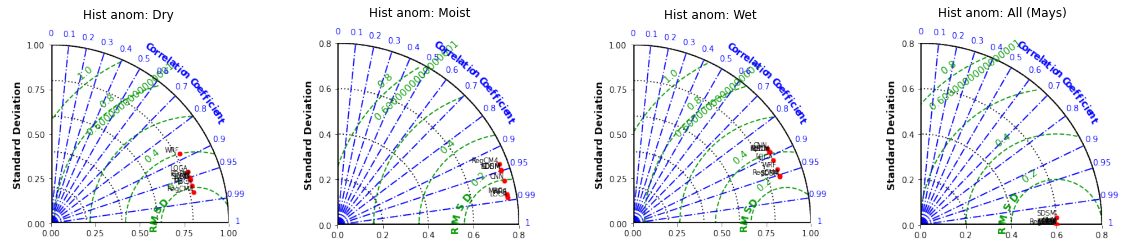

Variable:  V850 m/s


<Figure size 432x288 with 0 Axes>

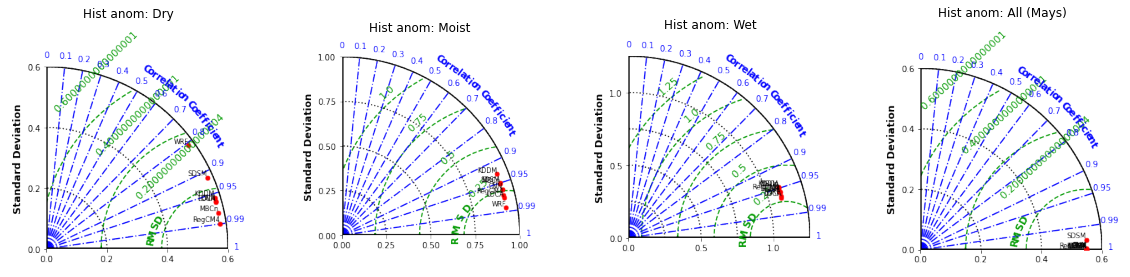

Variable:  Q850 kg/kg


<Figure size 432x288 with 0 Axes>

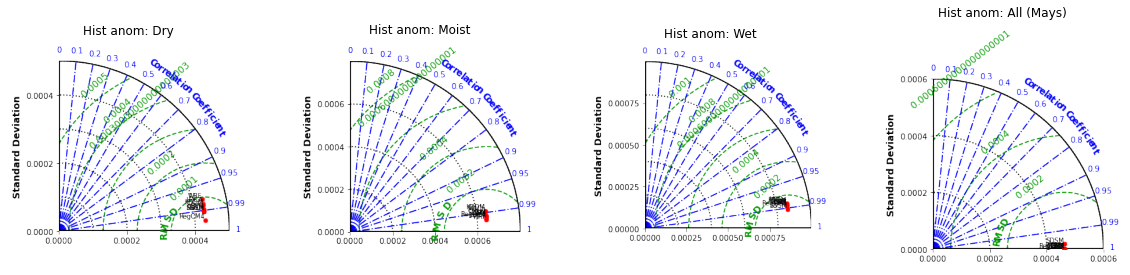

Variable:  T700 K


<Figure size 432x288 with 0 Axes>

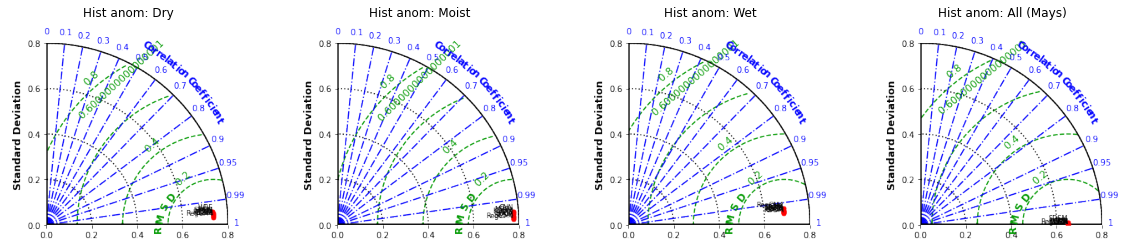

Variable:  Z700 mb


<Figure size 432x288 with 0 Axes>

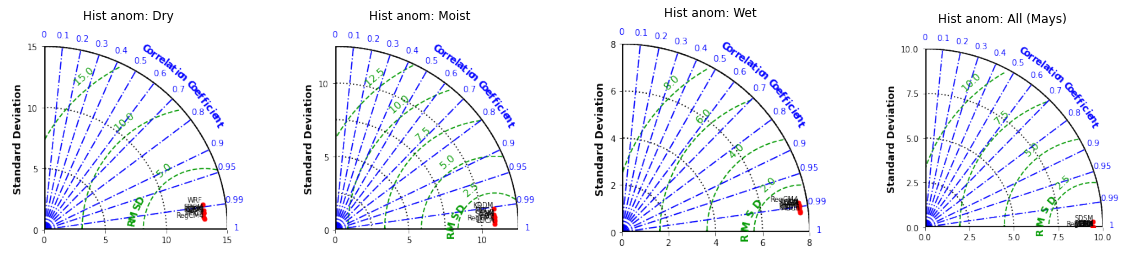

Variable:  Z500 mb


<Figure size 432x288 with 0 Axes>

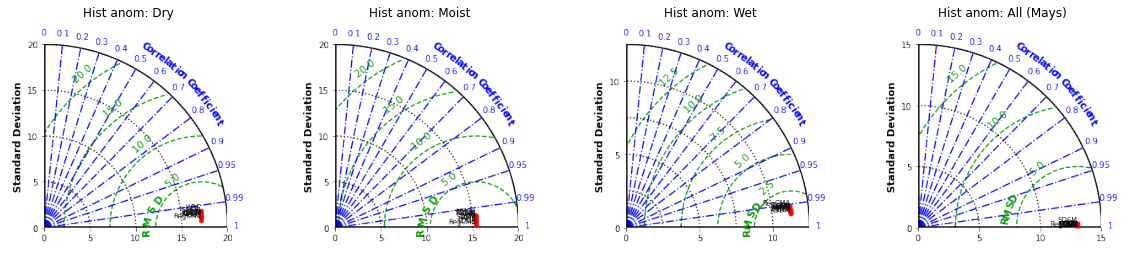

Variable:  U250 m/s


<Figure size 432x288 with 0 Axes>

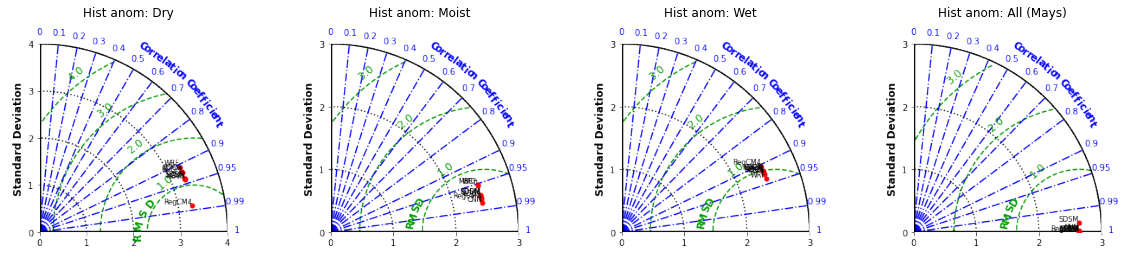

Variable:  V250 m/s


<Figure size 432x288 with 0 Axes>

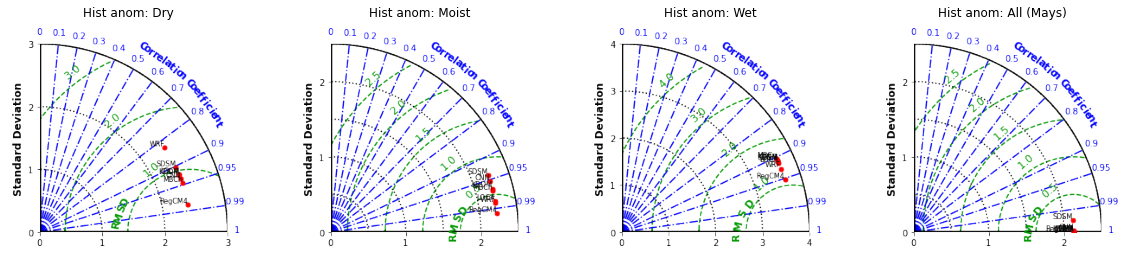

In [104]:
# Plot hist anomalies
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    print("Variable: ", varmames[vii], units[vii])

    sm.taylor_diagram(np.array(HAXX)[:,vii,0], np.array(HAYY)[:,vii,0], np.array(HAZZ)[:,vii,0], markerLabel=names)
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(HAXX)[:,vii,1], np.array(HAYY)[:,vii,1], np.array(HAZZ)[:,vii,1], markerLabel=names)
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(HAXX)[:,vii,2], np.array(HAYY)[:,vii,2], np.array(HAZZ)[:,vii,2], markerLabel=names)
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(HAXX)[:,vii,3], np.array(HAYY)[:,vii,3], np.array(HAZZ)[:,vii,3], markerLabel=names)
    plt.savefig(buf4, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    img4 = Image.open(buf4)

    # plot png inside a grid layout
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Hist anom: Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Hist anom: Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Hist anom: Wet')
    
    axarr[3].imshow(img4)
    axarr[3].axis('off')
    axarr[3].set_title('Hist anom: All (Mays)')
    

    plt.show()

### Future anomalies

In [106]:
# Calculate parameters for Taylor plots: dry/moist/wet

names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

# interate over models
FAXX=[]; FAYY=[]; FAZZ=[]
for mii in range(len(sigfiles_rcp85)):
    sigfn2 = sigfiles_rcp85[mii]
    rainsignal2 = xr.open_dataset(sigfn2)['prec']
            
    Y=[]
    load_uatm_mpi_future()
    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0), (0, 9999.0)]:
        avginput_rcp85, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, 5, -9999, 9999) 
        Y.append(avginput_rcp85)
   
    # baseline: raw
    if mii == 0:
        baseline_future = np.array(Y[3])

 
    sd83=[]; cr83=[]; sc83=[]
    for vii in range(8):
        sd3=[]; cr3=[]; sc3=[]
        for ii in range(4):            
            #sd = np.std(rainsignal1[:,0,0] - rainsignal2[:,0,0])
            #cr = ((diff[vii]-baseline[ii][vii])**2).mean()**0.5
            #sc, delme = spearmanr(baseline[ii][vii].flatten(),diff[vii].flatten())
            
            sd = np.std(np.array(Y[ii][vii]) - baseline_future[vii])
            cr = ((np.array(Y[ii][vii]) - baseline_future[vii])**2).mean()**0.5            
            sc, delme = spearmanr(baseline_future[vii].flatten(), np.array(Y[ii][vii]).flatten())
            
            sd3.append(float(sd))
            cr3.append(float(cr))
            sc3.append(float(sc))
            print(mii, vii, float(sd), float(cr), float(sc))
        sd83.append(sd3)
        cr83.append(cr3)
        sc83.append(sc3)
        
    FAXX.append(sd83)
    FAYY.append(cr83)
    FAZZ.append(sc83)

0 0 0.4637005117629438 0.503800442642615 0.9595441595441596
0 0 0.38613193668981394 0.41116179398543057 0.9696911963165834
0 0 0.7828014042320357 0.8285698174089124 0.8746776458837363
0 0 0.0 0.0 1.0
0 1 0.5667802510754288 0.6108447581260631 0.9865449445635206
0 1 0.3677757794693738 0.3793548816924087 0.9908383830365257
0 1 0.9679686584875627 1.0353516189178364 0.956570259232798
0 1 0.0 0.0 1.0
0 2 0.00038959437787594445 0.0004273917998332065 0.9819050391186616
0 2 0.0002698938549863872 0.00030002665585885 0.9947715946477558
0 2 0.000575286673342588 0.0006227582070540288 0.9833163098797776
0 2 0.0 0.0 1.0
0 3 0.31137102632646596 0.3331860578077624 0.9984289028251878
0 3 0.16039717102286177 0.20675084391440005 0.9997033685007375
0 3 0.5454739700050789 0.5605361687696937 0.9962848297213623
0 3 0.0 0.0 1.0
0 4 5.732663732804652 6.313953859100127 0.9960219805421046
0 4 3.150343160583439 3.1517213372419075 0.9984162013883379
0 4 9.18169274688159 10.4626936305341 0.9915680100200225
0 4 0.0 0

5 0 0.3711060565608501 0.4138919071263309 0.9732595944360651
5 0 0.42327876137381204 0.4885071514935129 0.9614678063972771
5 0 0.8283507767162644 0.891106991205839 0.8610335794236724
5 0 0.0 0.0 1.0
5 1 0.4444611286409682 0.47935617440662315 0.9907727589461338
5 1 0.40713704952685165 0.41803978748094694 0.9735693683681301
5 1 1.0214326727202427 1.095900937229665 0.9432789112046079
5 1 0.0 0.0 1.0
5 2 0.00029456459540634595 0.00032537447634644636 0.9895837633298934
5 2 0.00033489196040374354 0.00038452699119209227 0.9912430649272757
5 2 0.0005952351696588208 0.0006437136677576027 0.9826770042249922
5 2 0.0 0.0 1.0
5 3 0.2486383354970044 0.26508249505668513 0.9989383715699507
5 3 0.2247049315206928 0.2853343121334262 0.9995342806488319
5 3 0.5772710494381497 0.5932527053898042 0.9958021751210608
5 3 0.0 0.0 1.0
5 4 4.855383419552188 5.584245799378557 0.9975690861139779
5 4 3.7939184957406433 4.345775732783389 0.9988325262628671
5 4 10.391347561105224 11.878391943564576 0.990108050417648


Variable:  U850 m/s


<Figure size 432x288 with 0 Axes>

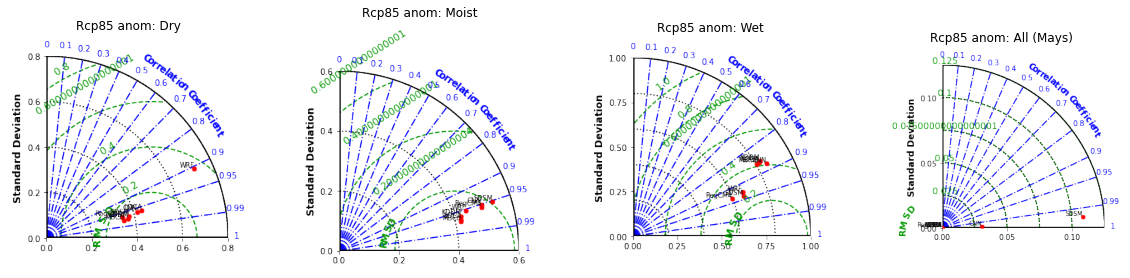

Variable:  V850 m/s


<Figure size 432x288 with 0 Axes>

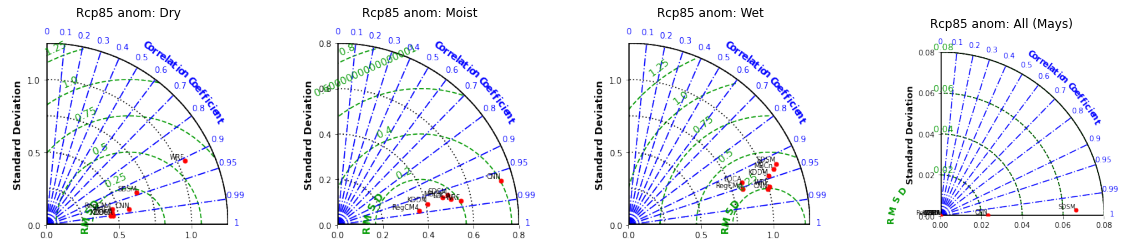

Variable:  Q850 kg/kg


<Figure size 432x288 with 0 Axes>

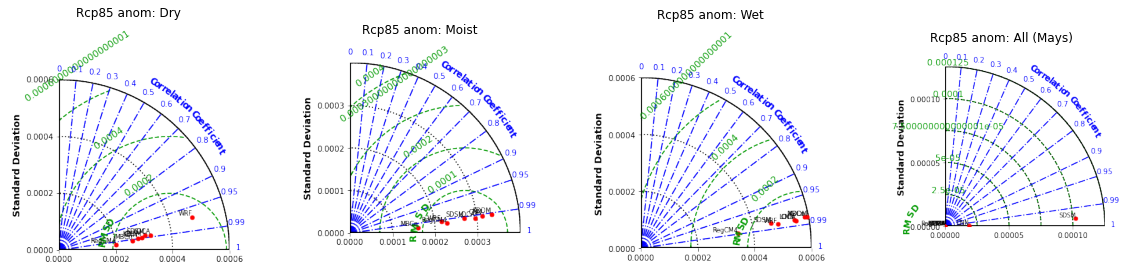

Variable:  T700 K


<Figure size 432x288 with 0 Axes>

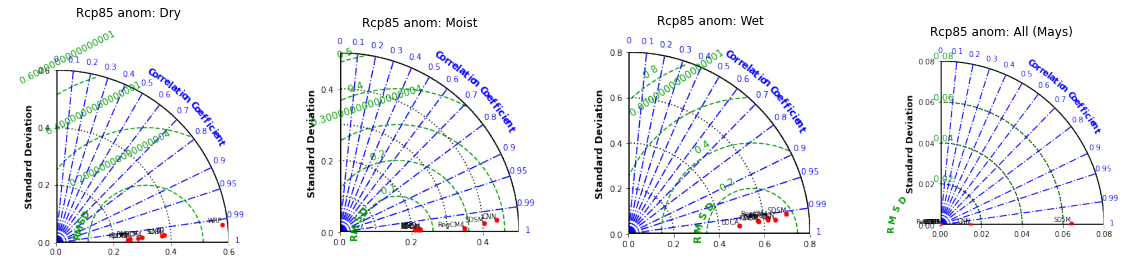

Variable:  Z700 mb


<Figure size 432x288 with 0 Axes>

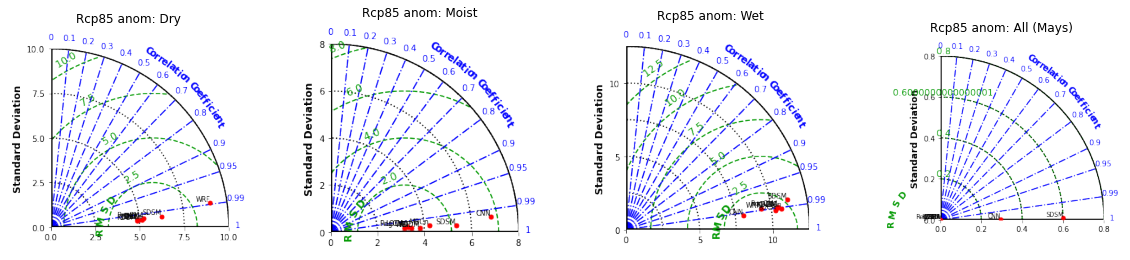

Variable:  Z500 mb


<Figure size 432x288 with 0 Axes>

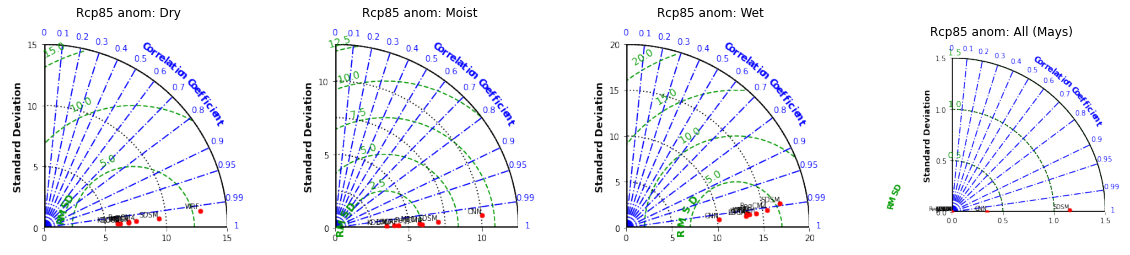

Variable:  U250 m/s


<Figure size 432x288 with 0 Axes>

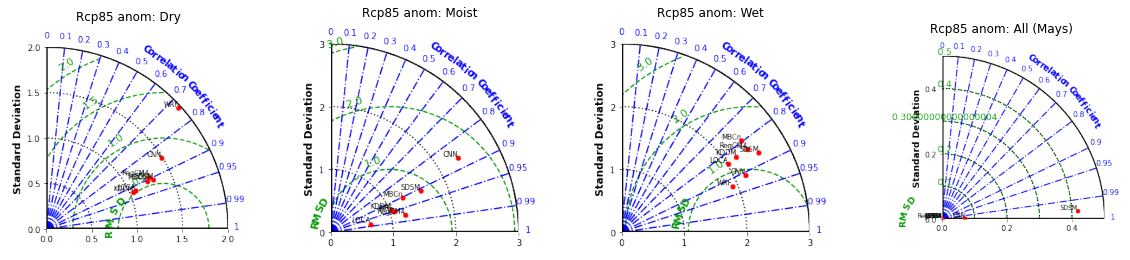

Variable:  V250 m/s


<Figure size 432x288 with 0 Axes>

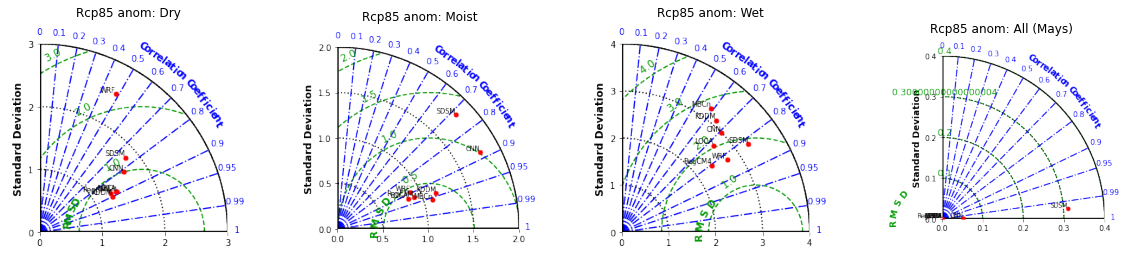

In [108]:
# Plot Future anomalies
# Plot Taylor plots
import skill_metrics as sm

# save plot as png in a fake in-memory file
import io, base64
from PIL import Image
import cv2

varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']


for vii in range(8):
    # fake files to write to
    buf1 = io.BytesIO()
    buf2 = io.BytesIO()
    buf3 = io.BytesIO()
    buf4 = io.BytesIO()
    
    print("Variable: ", varmames[vii], units[vii])

    sm.taylor_diagram(np.array(FAXX)[:,vii,0], np.array(FAYY)[:,vii,0], np.array(FAZZ)[:,vii,0], markerLabel=names)
    plt.savefig(buf1, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(FAXX)[:,vii,1], np.array(FAYY)[:,vii,1], np.array(FAZZ)[:,vii,1], markerLabel=names)
    plt.savefig(buf2, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(FAXX)[:,vii,2], np.array(FAYY)[:,vii,2], np.array(FAZZ)[:,vii,2], markerLabel=names)
    plt.savefig(buf3, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    sm.taylor_diagram(np.array(FAXX)[:,vii,3], np.array(FAYY)[:,vii,3], np.array(FAZZ)[:,vii,3], markerLabel=names)
    plt.savefig(buf4, format='png', bbox_inches='tight')
    plt.clf()   # Clear figure

    # load png
    buf1.seek(0)
    buf2.seek(0)
    buf3.seek(0)
    buf4.seek(0)
    img1 = Image.open(buf1)
    img2 = Image.open(buf2)
    img3 = Image.open(buf3)
    img4 = Image.open(buf4)

    # plot png inside a grid layout
    fig, axarr = plt.subplots(nrows=1, ncols=4, figsize = (20,20/4))

    axarr[0].imshow(img1)
    #axarr[0].axis('tight')
    axarr[0].axis('off')
    axarr[0].set_title('Rcp85 anom: Dry')

    axarr[1].imshow(img2)
    axarr[1].axis('off')
    axarr[1].set_title('Rcp85 anom: Moist')

    axarr[2].imshow(img3)
    axarr[2].axis('off')
    axarr[2].set_title('Rcp85 anom: Wet')
    
    axarr[3].imshow(img4)
    axarr[3].axis('off')
    axarr[3].set_title('Rcp85 anom: All (Mays)')
    

    plt.show()